In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand

LOSS_CLIPPING = 0.2
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 24
        self.learning_rate_actor = 0.0005
        self.learning_rate_critic = 0.0005
        self.epochs_cnt = 5
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
        
        self.discount_rate = 0.98
        self.smooth_rate = 0.95
        self.penalty = -100
        
        self.episode_num = 500
        self.mini_batch_step_size = 32        
        
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
 
        self.states, self.states_next, self.action_matrixs = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))
        
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrixs, advantages = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape:
                y_pred = self(states, training=True)
                new_policy = K.max(action_matrixs*y_pred, axis=-1)   
                old_policy = K.max(action_matrixs*out_action_probs, axis=-1)    
                r = new_policy/(old_policy)
                loss = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)

            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
    def build_model_actor(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_advantages = Input(shape=(1,self.value_size), name='input_advantages')

        x = (input_states)
        #he_normal, he_uniform, bias_initializer='he_normal', activation="elu", tf.nn.leaky_relu
        #glorot_uniform. glorot_normal
        x = Dense(self.node_num, activation="relu", kernel_initializer='glorot_normal')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_advantages], outputs=out_actions)
        model.compile(optimizer=Adam(lr=self.learning_rate_actor))
        
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        x = (input_states)
        x = Dense(self.node_num, activation="relu", kernel_initializer='glorot_normal')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(lr=self.learning_rate_critic),
                      loss = "binary_crossentropy"
#                       loss='mean_squared_error'
                     )
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            state = state[0]
            self.env.max_episode_steps = 500

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
                
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrixs = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        
        while not done:
#         while count < 100:
            count+=1

            state_t = np.reshape(self.normalize(state),[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE])
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none, none2 = self.env.step(action)
            
            state_next_t = np.reshape(self.normalize(state_next),[1, 1, self.state_size])
            
            if count < 500 and done:
                reward = self.penalty 
        
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))
            
            if(count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()

            reward_tot += reward
            state = state_next
            
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0, 0, 0, 0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0, len(rewards))):
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate * values_next[t] * dones[t]
            adv = delta_adv + self.smooth_rate * self.discount_rate * dones[t] * adv
            target = delta_tar + self.smooth_rate * self.discount_rate * dones[t] * target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def normalize(self, x):
#         current_mean = np.mean(x)
#         current_std = np.std(x)
#         x_normed = (x - current_mean) / current_std
#         return x_normed
        norm = np.linalg.norm(x)
        if norm == 0: 
            return x
        return x / norm
    
    def train_mini_batch(self):
        
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrixs_t = np.array(self.action_matrixs)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)

        values = self.model_critic.predict(states_t)
        values_next = self.model_critic.predict(states_next_t)
        
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)

        self.model_actor.fit([states_t, action_matrixs_t, advantages_t], [action_probs_t], epochs=5, verbose=0)
        self.model_critic.fit(states_t, targets_t, epochs=5, verbose=0)       
        
    def save_model(self):
        self.model_actor.save("./model/ppo_tunned")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_states (InputLayer)       [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 24)        120         input_states[0][0]               
__________________________________________________________________________________________________
input_action_matrixs (InputLaye [(None, 1, 2)]       0                                            
__________________________________________________________________________________________________
input_advantages (InputLayer)   [(None, 1, 1)]       0                                            
___________________________________________________________________________________________

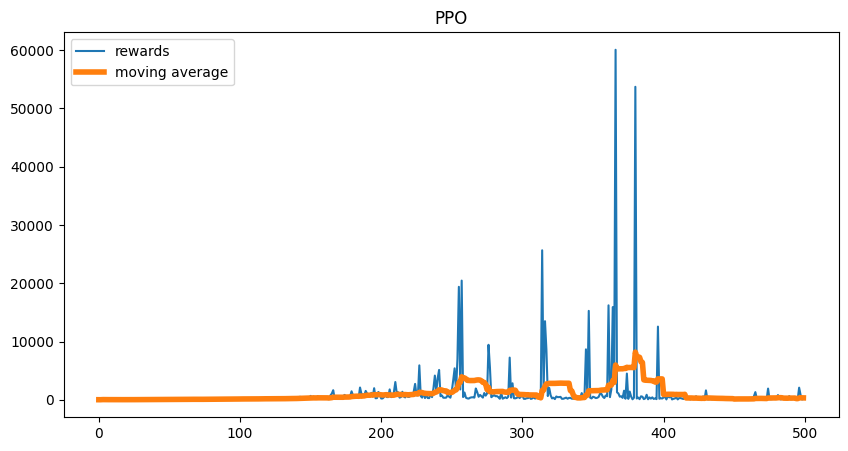

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('PPO')
plt.show()